![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [7]:
import warnings
warnings.filterwarnings('ignore')

# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import  cross_val_score


In [2]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
X = data.drop(['Price'], axis=1)
y = data['Price']

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
class ArbolDecisiones:
  
  def fit(self, X, y, min_leaf = 2):
    self.dtree = Node(X, y, np.array(np.arange(len(y))), min_leaf)
    return self
  
  def predict(self, X):
    return self.dtree.predict(X.values)

In [ ]:
class Node:

    def __init__(self, x, y, idxs, min_leaf=2):
        self.x = x 
        self.y = y
        self.idxs = idxs 
        self.min_leaf = min_leaf
        self.row_count = len(idxs)
        self.col_count = x.shape[1]
        self.val = np.mean(y.iloc[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for c in range(self.col_count): self.find_better_split(c)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        self.lhs = Node(self.x, self.y, self.idxs[lhs], self.min_leaf)
        self.rhs = Node(self.x, self.y, self.idxs[rhs], self.min_leaf)
        
    def find_better_split(self, var_idx):
      
        x = self.x.values[self.idxs, var_idx]

        for r in range(self.row_count):
            lhs = x <= x[r]
            rhs = x > x[r]
            if rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf: continue

            curr_score = self.find_score(lhs, rhs)
            if curr_score < self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = x[r]
                
    def find_score(self, lhs, rhs):
        y = self.y.iloc[self.idxs]
        lhs_std = y.iloc[lhs].std()
        rhs_std = y.iloc[rhs].std()
        return lhs_std * lhs.sum() + rhs_std * rhs.sum()
                
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]
                
    @property
    def is_leaf(self): return self.score == float('inf')                

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.predict_row(xi)

In [ ]:
# Creación y Predicción del Modelo (Nota: Esto puede tardar varios minutos)
regressor = ArbolDecisiones().fit(X_train, y_train)
preds = regressor.predict(X_test)

In [ ]:
# Métricas
rmse = np.sqrt(np.square(y_test - preds).mean())
mae = np.mean(np.abs(y_test - preds))
r2 = r2_score(y_test, preds)

print("RMSE: ", rmse) 
print("MAE: ", mae)
print('R2: ',r2)

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 2
#juan A

# Se crea un arreglo de 1 a 20
np.random.seed(1)

# Impresión de arreglo y muestreo aleatorio
nums = np.arange(1, 21)
print('Arreglo:', nums)
print('Muestreo aleatorio: ', np.random.choice(a=nums, size=20, replace=True))

# Creación de 10 muestras de bootstrap 
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

# Visualización muestra boostrap #1 para entremiento
X_train.iloc[samples[0], :]


# Construcción un árbol de decisión para cada muestra boostrap

from sklearn.tree import DecisionTreeRegressor

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train = train.iloc[sample, 1:]
    y_train = train.iloc[sample, 0]
    treereg.fit(X_train, y_train)
    y_pred.iloc[:,i] = treereg.predict(X_test)
    
y_pred

# Desempeño de cada árbol
for i in range(n_B):
    print('Árbol ', i, 'tiene un error: ', np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_test)))
    
# Predicciones promedio para cada obserbación del set de test
y_pred.mean(axis=1)

# Error al promediar las predicciones de todos los árboles
np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1)))



### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 3
#Juan A


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [47]:
# Celda 4
# Implementación modelo Random Forest para Regresión
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE: ', mse)
print('R2: ', r2)

pd.Series(cross_val_score(rf_model, X, y, cv=10,scoring='r2')).describe()

MSE:  3096029.5653429343
R2:  0.7975941385309026


count    10.000000
mean      0.801334
std       0.010942
min       0.781610
25%       0.795265
50%       0.803561
75%       0.805631
max       0.816167
dtype: float64

Aplicando el modelo de Random Forest para predecir el precio de un automóvil se tiene un MSE de 3.078.505 y un R2 de 0.79, esto sin realizar calibración de parámetros. Adicionalmente se realiza con un modulo de "ensemble" utilizando validación cruzada y después de aplicar con k-fold cross validation un k de 10 se obtiene la distribución del r2 identificando así que el promedio del r2 está en 0.80 con un mínimo del 0.78 y un máximo de 0.81 siendo un resultado no tan disperso.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

**************************Calibración de n_estimators************************


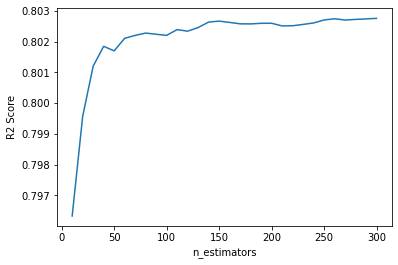

**************************Calibración de max_features************************


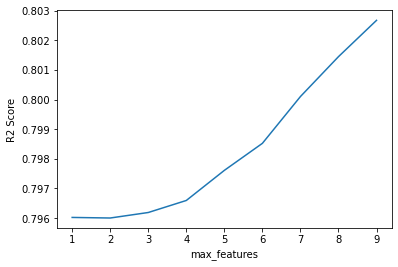

**************************Calibración de max_depth************************


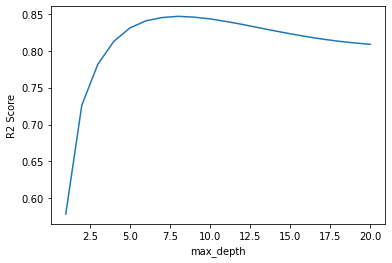

In [29]:
# Celda 5

print('**************************Calibración de n_estimators************************')
estimator_range = range(10, 310, 10)
R2_scores = []
for estimator in estimator_range:
    rf_model = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    R2_scores.append(cross_val_score(rf_model, X, y, cv=5, scoring='r2').mean())

plt.plot(estimator_range, R2_scores)
plt.xlabel('n_estimators')
plt.ylabel('R2 Score')
plt.show()

print('**************************Calibración de max_features************************')
feature_range = range(1, len(X.columns)+1)
R2_scores = []
for feature in feature_range:
    rf_model = RandomForestRegressor(n_estimators=150, max_features=feature, random_state=1, n_jobs=-1)
    R2_scores.append(cross_val_score(rf_model, X, y, cv=5, scoring='r2').mean())
    
plt.plot(feature_range, R2_scores)
plt.xlabel('max_features')
plt.ylabel('R2 Score')
plt.show()

print('**************************Calibración de max_depth************************')
depth_range = range(1, 21)
R2_scores = []

for depth in depth_range:
    rf_model = RandomForestRegressor(n_estimators=150, max_depth=depth, random_state=1, n_jobs=-1)
    R2_scores.append(cross_val_score(rf_model, X, y, cv=5, scoring='r2').mean())
    
plt.plot(depth_range, R2_scores)
plt.xlabel('max_depth')
plt.ylabel('R2 Score')
plt.show()

Se procede a validar los parámetros más optimos para aplicar al modelo, iniciando con el número de arboles (n_estimators) que van a ser usados se selecciona  un rango entre 10 y 310 para probar el cambio en los resultados del r2 a medida que va iterando sobre esta variable y por cada arbol se está haciendo una validación cruzada de 5, para este caso se evidencia que se alcanza el máximo r2 con aproximadamente 150 árboles valor superior al que trae el modleo por default.

Posteriormente se busca identificar el número máximo de variables (max_features) con las cuáles nuestro modelo tendría un mejor desempeño, para lo cuál se itera sobre el número total de variables que tenemos en el dataset, sin embargo en este caso al tener pocas variables nos arroja que el r2 llega a su punto máximo cuando toma todas las variables entendiendo que los árboles serían iguales y ya no tendrían tanta aleatoriedad. Esto podría ser de mayor impacto si tuvieramos un mayor número de variables en nuestro dataset.

Por último se realiza iteración sobre la profundidad de los árboles (max_depth) en donde se busca limitar la profundidad que puede alcanzar cada arbol de decisión individual en donde para este caso se evidencia que alcanza un máximo r2 con aproximadamente 7.5.

In [46]:
#Implementación del modelo Random Forest para Regresión con los mejores parámetros

rf_model = RandomForestRegressor(n_estimators=150, max_depth=8,max_features=9)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('***Métricas para Test:')
print('MSE: ', mse)
print('R2: ', r2)
print('***Métricas para Train:')
rf_model = RandomForestRegressor(n_estimators=150, max_depth=8,max_features=9)
rf_model.fit(X_train, y_train)
y_pred_train = rf_model.predict(X_train)
mse = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)
print('MSE: ', mse)
print('R2: ', r2)

***Métricas para Test:
MSE:  2453094.656839763
R2:  0.8396266163472846
***Métricas para Trian:
MSE:  1853997.0147188692
R2:  0.8798008523096728


En este paso se entrena el modelo  Random Forest utilizando los mejores parametros identificados en el paso anterior con lo cuál se evidencia un mejor desempeño del modelo con calibración de parámetros en donde se obtuvo un r2 0.83 frente al modelo aplicado en el punto 4 con el cuál se obtuvo un r2 0.79. Adicionalmente se validan las metricas de desempñeo sobre train con el fin de descartar que el modelo tenga overfitting encontrando un buen resultado también para este caso.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6
#JUan F

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 7
#JUan F

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8
